# DAC Contest
This reference design will help you walk through a reference design.
It is simplified to help users understand the flow. However, 
in the real contest, users should still implement all the required functions.

If you have any question, please contact [Xinyi Zhang at University of Pittsburgh](mailto:xinyizhang@pitt.edu).

## Hardware
A simplified block diagram is shown as follows:

![](../block_diagram.png)

Note that in this block diagram, no actual image processing is done.
Pictures are:
1. sent from PS to DMA, then DMA to FIFO
2. sent back from FIFO to DMA, then DMA to PS.

Note that the FIFO should be replaced with meaningful pipeline to process the pictures.

## Software
Note:
1. Any change in `preprocessing.py` will make your design fail in evaluation. This file should not be changed.
2. Only "resize" is allowed on PS side. Any other inference executed on PS side would be regarded as fail.

Time for a batch processing should start before "PS reading images" and end after "PS receiving all results". 
Please check the reference for details.

Batch size is 500 by default.

Please write your results using the methods `write()` and `save_results_xml()`.

It is your choice how to record the inference result. 
However, it must be readable, and you must convert it to XML files. An example is provided.
Please pack your code into `teamname.py`. 
Your design should be able to process all evaluation images with one click.

### 1. Importing all libraries

In [1]:
import sys
import math
import numpy as np
import os
import time
from PIL import Image
from matplotlib import pyplot
import cv2
from datetime import datetime
from pynq import Xlnk
from pynq import Overlay
from preprocessing import Agent
from preprocessing import BATCH_SIZE
from preprocessing import get_image_path

team = 'pynquser'
agent = Agent(team)

Your raw data will be kept in `agent.coord_team`.

Your XML files will be kept in `agent.xml_team`.

The following cell is not a real design for image detection. But you can
use it to start your design.

### 2. Preparing the overlay
The DMA instance is exposed as an attribute of the overlay object.

In [2]:
overlay = Overlay("/home/xilinx/jupyter_notebooks/dac_contest/overlay/"
                  "dac_contest.bit")
dma = overlay.axi_dma_0

Data flows from PS to PL, then back to PS by DMA. Using interrupt is recommended.

### 3. Resizing a single picture
The picture pixel data can be read using `opencv` library.

In the following example, we will show how to use only the software to resize
an image in the batch.

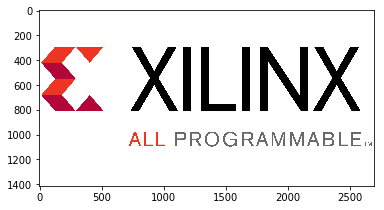

Original image size: 1414x2700 pixels.


In [3]:
interval_time = 0
image_path = get_image_path('xilinx.jpg')

original_image = Image.open(image_path)
original_array = np.array(original_image)
original_image.close()

pyplot.imshow(original_array, interpolation='nearest')
pyplot.show()

old_width, old_height = original_image.size
print("Original image size: {}x{} pixels.".format(old_height, old_width))

Note that this is quite a high-definition picture. 
So you will be resizing this picture to a specific width or height.
The coordinates of the resized picture will be recorded as part of your result.

In the following example, we will resize the image by reducing both the height 
and width by 50%.

Note: This is a software example, so you will notice it is quite slow. In the design
contest, you can explore hardware acceleration for this kind of image processing.

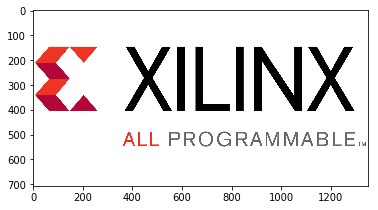

Resized image size: 707x1350 pixels.


In [4]:
new_width, new_height = int(old_width/2), int(old_height/2)
original_image = Image.open(image_path)
resized_image = original_image.resize((new_width, new_height), 
                                      Image.ANTIALIAS)
resized_array = np.array(resized_image)
original_image.close()

pyplot.imshow(resized_array, interpolation='nearest')
pyplot.show()

width, height = resized_image.size
print("Resized image size: {}x{} pixels.".format(height, width))

### 4. Pushing a picture through the pipeline
In the following example, we will also use contiguous memory arrays for sending
and receiving data.

The size of the buffer depends on the size of the input or output data.
Since the image we process in the following example (`pynq.jpg`) has 263x358 RGB pixels,
we will use `cma_array` of the corresponding size as well.

In [5]:
xlnk = Xlnk()
in_buffer = xlnk.cma_array(shape=(263, 358, 3), dtype=np.uint8)
out_buffer = xlnk.cma_array(shape=(263, 358, 3), dtype=np.uint8)

Note: In the following example, we are only dealing with one image. 
We will just send one image to the FIFO and loop it back. 
In the real contest, you should process all the RGB images in every batch.

Note that the `rgb_array` has to be copied into the contiguous memory array
(deep copy).

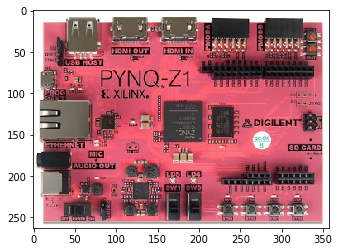

In [6]:
interval_time = 0

image_path = get_image_path('pynqz1.jpg')
bgr_array = cv2.imread(image_path)
rgb_array = cv2.cvtColor(bgr_array, cv2.COLOR_BGR2RGB)
in_buffer[:] = rgb_array

pyplot.imshow(in_buffer)
pyplot.show()

Now we will push the data from input buffer through the pipeline to the output buffer.

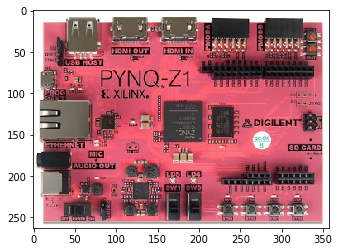

In [7]:
def dma_transfer():
    dma.sendchannel.transfer(in_buffer)
    dma.recvchannel.transfer(out_buffer)
    dma.sendchannel.wait()
    dma.recvchannel.wait()

dma_transfer()

pyplot.imshow(out_buffer)
pyplot.show()

### 5. Timing

You should measure the time for processing all the images. Timer should start 
before "PS reading images" and end after "PS receiving results".

It is easy to time the processing of multiple pictures or batches.
In the following example, we will time the processing of a single picture.

In [8]:
interval_time = 0
total_time = 0
total_num_img = len(agent.img_list)
result = list()
agent.reset_batch_count()

for i in range(math.ceil(total_num_img/BATCH_SIZE)):
    # get a batch from agent
    batch = agent.send(interval_time, agent.img_batch)

    # choose a single image from the batch
    first_image = sorted(batch)[0]

    # timer start when PS reading image
    start = time.time()
    bgr_array = cv2.imread(get_image_path(first_image))
    rgb_array = cv2.cvtColor(bgr_array, cv2.COLOR_BGR2RGB)
    in_buffer[:] = rgb_array
    dma_transfer()

    # timer stop after PS has received image
    end = time.time()
    t = end - start
    print('Processing time: {} seconds.'.format(t))
    total_time += t
    result.append(str(out_buffer))

Processing time: 0.017682790756225586 seconds.


### 6. Recording results

It is your responsibility to record the output raw data.

You can put batches results in separate files or a single file. 

Please use `write()` to record your time performance. 
Your coordinates should be written into `dac_contest/result/coordinate/teamname/...`.
Please put all your intermediate result there. 
However, it is your choice how to store them.

In [9]:
agent.write(total_time, total_num_img, team)

with open(agent.coord_team + '/{}.txt'.format(team), 'w+') as fcoord:
    for element in result:
        fcoord.write(element)
        fcoord.write('\n')
print("Coordinate results written successfully.")

Coordinate results written successfully.


The following cell is an example showing how to write coordinates to XML.

Continuing the above example:

1. There are 2 pictures in the image folder currently, so the length of the `result_rectangle` is 2. 

2. Each element in `result_rectangle` is a 4-integer list: [xmin, xmax, ymin, ymax].

3. Since we have resized one of the images to 707x1350 pixels, we will set that result accordingly.

In [10]:
result_rectangle =  [[0,358,0,263],[0,1350,0,707]]

agent.save_results_xml(result_rectangle)
print("XML results written successfully.")

XML results written successfully.


### 7. Cleaning up
Remember to free the contiguous memory after usage.

In [11]:
xlnk.xlnk_reset()